<!--
 * @file        8_localization.ipynb
 * @brief       This notebook provides Extended Kalman Filter based localization using GNSS and IMU data.
 *
 * @authors     Jaehwan Lee (idljh5529@gmail.com)
 *
 * @date        2025-08-13 Released by AI Lab, Hanyang University
 *
-->

# 8. EKF 기반 차량 위치 추정 (Localization)

이번 실습에서는 **확장 칼만 필터(Extended Kalman Filter, EKF)**를 사용하여 실제 센서 데이터로부터 차량의 위치를 추정하는 방법을 학습합니다.

## 실습 목표

1. **EKF 이론 이해**: 선형 칼만 필터와 EKF의 차이점 및 야코비안 행렬 개념
2. **Dead Reckoning 모델**: IMU 데이터를 활용한 차량 운동 모델링  
3. **센서 융합**: GNSS와 IMU 데이터의 융합을 통한 정확한 위치 추정
4. **좌표계 변환**: WGS84(위경도) ↔ ENU(동-북-상) 좌표계 변환
5. **실시간 위치 추정**: 연속적인 센서 데이터 처리 및 위치 업데이트
6. **결과 시각화**: 애니메이션 및 위성 지도를 통한 추정 결과 분석

## EKF vs 선형 칼만 필터

### 주요 차이점
- **선형 KF**: 선형 시스템 모델 ($x_{k+1} = Fx_k + Gu_k$)
- **EKF**: 비선형 시스템 모델 ($x_{k+1} = f(x_k, u_k)$)을 선형화하여 적용

### EKF의 필요성
차량의 운동은 **비선형** 특성을 가집니다:
- 차량의 요각(yaw)에 따라 속도 벡터의 방향이 변함
- $x_{k+1} = x_k + v_x \cos(\psi_k) \Delta t - v_y \sin(\psi_k) \Delta t$
- $y_{k+1} = y_k + v_x \sin(\psi_k) \Delta t + v_y \cos(\psi_k) \Delta t$

이러한 삼각함수가 포함된 비선형 모델을 처리하기 위해 EKF를 사용합니다.

In [2]:
# 외부에 정의된 파이썬 모듈(.py 파일)을 수정할 때마다 매번 커널을 재시작하지 않아도 변경 사항이 자동으로 반영되도록 설정
%load_ext autoreload
%autoreload 2

In [24]:
# 필요한 라이브러리 임포트
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 사용자 정의 localization 모듈 임포트
sys.path.append('./tutlibs/localization')
from tutlibs.localization.custom_localization import (
    SensorDataLoader,
    LocalizationVisualizer
)

print("라이브러리 임포트 완료!")
print("Python 버전:", sys.version)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)
print("Matplotlib 버전:", plt.matplotlib.__version__)

라이브러리 임포트 완료!
Python 버전: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
NumPy 버전: 2.2.6
Pandas 버전: 2.3.2
Matplotlib 버전: 3.10.5


## 1. 센서 데이터 로딩

실제 취득한 데이터를 정리한 csv 파일에서 GNSS와 IMU, wheel speed sensor 데이터를 로드하고 분석합니다.

In [4]:
# Step 1: CSV 데이터 추출
print("=== Step 1: ROS bag -> CSV 추출 ===")

# CSV 추출 스크립트 실행 여부 확인
csv_dir = "./../data/localization"
import os

print(f"✅ CSV 디렉토리 존재: {csv_dir}")
csv_files = os.listdir(csv_dir)
print(f"📁 발견된 CSV 파일들: {csv_files}")


=== Step 1: ROS bag -> CSV 추출 ===
✅ CSV 디렉토리 존재: ./../data/localization
📁 발견된 CSV 파일들: ['gps_fix.csv', 'gps_gps.csv', 'gps_imu.csv', 'novatel_oem7_inspvax.csv', 'vehicle_motion_sensor.csv']


In [5]:
# Step 2: CSV 데이터 로딩 및 변환
print("=== Step 2: CSV 데이터 로딩 ===")

# 센서 데이터 로더 생성
data_loader = SensorDataLoader()

try:
    # CSV 데이터 로딩
    csv_data = data_loader.load_from_csv(csv_dir)
    
    # Localization 형태로 변환
    sensor_data_csv = data_loader.convert_csv_to_localization_format(csv_data) # TODO: 4개의 wheel speed로부터 차량 속도 추출
    
    # 데이터 확인
    print(f"\n=== 로딩된 센서 데이터 확인 ===")
    for key, df in sensor_data_csv.items():
        if not df.empty:
            print(f"✅ {key}: {len(df)} 포인트")
            if 'timestamp' in df.columns:
                time_range = df['timestamp'].max() - df['timestamp'].min()
                print(f"   시간 범위: {time_range:.1f} 초")
            print(f"   컬럼: {list(df.columns)[:5]}{'...' if len(df.columns) > 5 else ''}")
        else:
            print(f"⚠️ {key}: 데이터 없음")
    
    # 주요 데이터 시각화
    if not sensor_data_csv['inspvax'].empty:
        inspvax_df = sensor_data_csv['inspvax']
        print(f"\n📊 INSPVAX 데이터 미리보기:")
        print(f"   위도 범위: {inspvax_df['latitude'].min():.6f} - {inspvax_df['latitude'].max():.6f}")
        print(f"   경도 범위: {inspvax_df['longitude'].min():.6f} - {inspvax_df['longitude'].max():.6f}")
        
        if 'azimuth' in inspvax_df.columns:
            print(f"   방위각 범위: {inspvax_df['azimuth'].min():.1f} - {inspvax_df['azimuth'].max():.1f} 도")
        
        # 정확도 정보
        if 'latitude_stdev' in inspvax_df.columns:
            print(f"   위도 표준편차: {inspvax_df['latitude_stdev'].mean():.4f} m")
            print(f"   경도 표준편차: {inspvax_df['longitude_stdev'].mean():.4f} m")
    
    if not sensor_data_csv['motion_sensor'].empty:
        wheel_df = sensor_data_csv['motion_sensor']
        print(f"\n🚗 Vehicle CAN 데이터 미리보기:")
        print(f"   FL 속도 범위: {wheel_df['wheel_speed_fl'].min():.2f} - {wheel_df['wheel_speed_fl'].max():.2f} m/s")
        print(f"   FR 속도 범위: {wheel_df['wheel_speed_fr'].min():.2f} - {wheel_df['wheel_speed_fr'].max():.2f} m/s")
        if 'yaw_rate' in wheel_df.columns:
            print(f"   Yaw Rate 범위: {wheel_df['yaw_rate'].min():.3f} - {wheel_df['yaw_rate'].max():.3f} rad/s")
        
        # 평균 속도 계산
        avg_speed = (wheel_df['wheel_speed_fl'] + wheel_df['wheel_speed_fr'] + 
                    wheel_df['wheel_speed_rl'] + wheel_df['wheel_speed_rr']) / 4.0
        print(f"   평균 속도 범위: {avg_speed.min():.2f} - {avg_speed.max():.2f} m/s")
        
except Exception as e:
    print(f"❌ CSV 데이터 로딩 실패: {e}")
    import traceback
    traceback.print_exc()


=== Step 2: CSV 데이터 로딩 ===
📁 CSV 디렉토리에서 데이터 로딩: ..\data\localization
✅ novatel_oem7_inspvax.csv: 44878 행, 27 컬럼
   시간 범위: 1754911229.5 - 1754911673.8 초 (총 444.3초)
✅ vehicle_motion_sensor.csv: 204405 행, 28 컬럼
   시간 범위: 1754911229.5 - 1754911673.8 초 (총 444.3초)
✅ gps_gps.csv: 20598 행, 5 컬럼
   시간 범위: 1754911229.5 - 1754911673.8 초 (총 444.3초)
✅ gps_fix.csv: 20599 행, 21 컬럼
   시간 범위: 1754911229.5 - 1754911673.8 초 (총 444.3초)
✅ gps_imu.csv: 44435 행, 33 컬럼
   시간 범위: 1754911229.5 - 1754911673.8 초 (총 444.3초)

📊 총 5/5 개 CSV 파일 로딩 완료
✅ INSPVAX -> GNSS 변환: 44878 포인트
✅ Vehicle Motion Sensor -> Motion Sensor 변환: 204405 포인트
-0.0003490658503988
✅ GPS GPS 데이터: 20598 포인트

📋 Localization 데이터 변환 완료:
   ✅ gnss: 44878 포인트
   ⚠️ imu: 데이터 없음
   ⚠️ gps_imu: 데이터 없음
   ✅ motion_sensor: 204405 포인트
   ✅ inspvax: 44878 포인트
   ⚠️ odom: 데이터 없음
   ✅ gps_gps: 20598 포인트

=== 로딩된 센서 데이터 확인 ===
✅ gnss: 44878 포인트
   시간 범위: 444.3 초
   컬럼: ['timestamp', 'latitude', 'longitude', 'altitude', 'covariance']
⚠️ imu: 데이터 없음
⚠️ gps_imu

✅ 시간 범위: 1754911229.5 ~ 1754911673.8 초


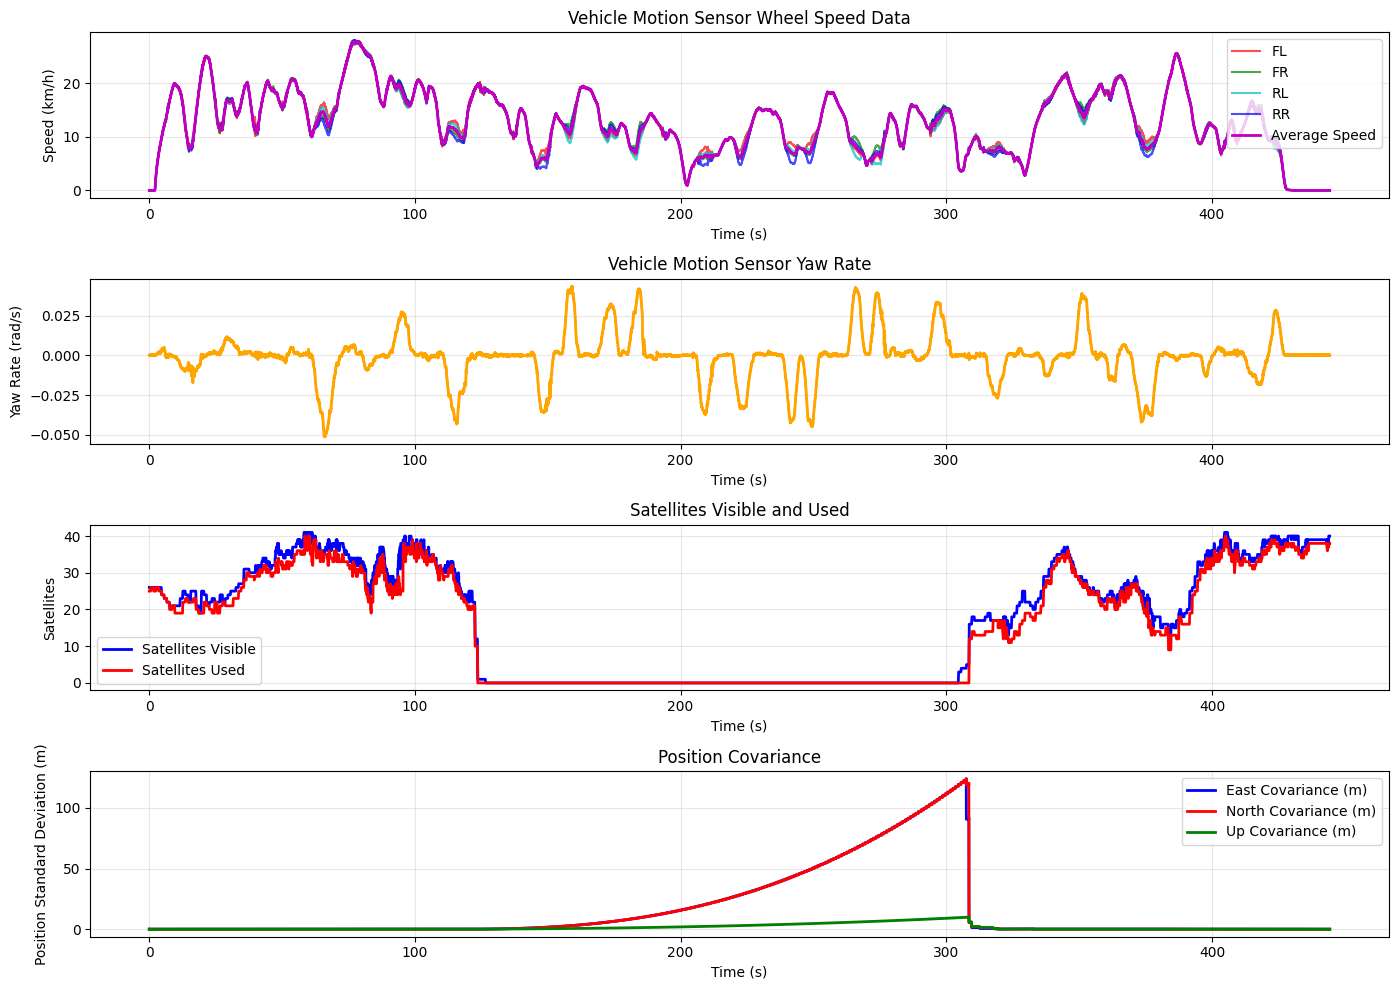

In [6]:
# 데이터 시각화 - Wheel Speed, Yaw Rate, INSPVAX 궤적, 위성 수 및 사용 위성 수, 위치 불확실도
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# 여러 데이터들이 모두 존재하는 시간 시작점 및 종료점 찾기
start_time = 1999999999.9 
end_time = 0.0
for key, df in sensor_data_csv.items():
    if not df.empty:
        if 'timestamp' in df.columns:
            start_time_df = df['timestamp'].min()
            end_time_df = df['timestamp'].max()

            if start_time > start_time_df:
                start_time = start_time_df
            if end_time < end_time_df:
                end_time = end_time_df

print(f"✅ 시간 범위: {start_time:.1f} ~ {end_time:.1f} 초")

# Wheel Speed 데이터 시각화
time_rel_csv = (sensor_data_csv['motion_sensor']['timestamp'] - start_time)
axes[0].plot(time_rel_csv, sensor_data_csv['motion_sensor']['wheel_speed_fl'], 
            'r-', alpha=0.7, label='FL')
axes[0].plot(time_rel_csv, sensor_data_csv['motion_sensor']['wheel_speed_fr'], 
            'g-', alpha=0.7, label='FR')
axes[0].plot(time_rel_csv, sensor_data_csv['motion_sensor']['wheel_speed_rl'], 
            'c-', alpha=0.7, label='RL')
axes[0].plot(time_rel_csv, sensor_data_csv['motion_sensor']['wheel_speed_rr'], 
            'b-', alpha=0.7, label='RR')
axes[0].plot(time_rel_csv, sensor_data_csv['motion_sensor']['average_speed'], 
            'm-', linewidth=2, label='Average Speed')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Speed (km/h)')
axes[0].set_title('Vehicle Motion Sensor Wheel Speed Data')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Yaw Rate 시각화
axes[1].plot(time_rel_csv, sensor_data_csv['motion_sensor']['yaw_rate'], 
            'orange', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Yaw Rate (rad/s)')
axes[1].set_title('Vehicle Motion Sensor Yaw Rate')
axes[1].grid(True, alpha=0.3)

# 위성 수 시각화
time_rel_csv = (sensor_data_csv['gps_gps']['timestamp'] - start_time)
axes[2].plot(time_rel_csv, sensor_data_csv['gps_gps']['satellites_visible'], 
            'b-', linewidth=2, label='Satellites Visible')
axes[2].plot(time_rel_csv, sensor_data_csv['gps_gps']['satellites_used'], 
            'r-', linewidth=2, label='Satellites Used')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Satellites')
axes[2].set_title('Satellites Visible and Used')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# 위치 불확실도 시각화
# covariance는 각 행이 길이 9인 리스트이므로, 리스트에서 인덱스를 추출해야 함
position_covariance_x = np.sqrt([cov[0] for cov in sensor_data_csv['gnss']['covariance']])
position_covariance_y = np.sqrt([cov[4] for cov in sensor_data_csv['gnss']['covariance']])
position_covariance_z = np.sqrt([cov[8] for cov in sensor_data_csv['gnss']['covariance']])
time_rel_csv = (sensor_data_csv['gnss']['timestamp'] - start_time)
axes[3].plot(time_rel_csv, position_covariance_x, 
            'b-', linewidth=2, label='East Covariance (m)')
axes[3].plot(time_rel_csv, position_covariance_y, 
            'r-', linewidth=2, label='North Covariance (m)')
axes[3].plot(time_rel_csv, position_covariance_z, 
            'g-', linewidth=2, label='Up Covariance (m)')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Position Standard Deviation (m)')
axes[3].set_title('Position Covariance')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# INSPVAX 궤적 (2D)
fig, axes = plt.subplots(1, 1)
axes.plot(sensor_data_csv['inspvax']['longitude'], sensor_data_csv['inspvax']['latitude'], 
            'blue', linewidth=2, label='INSPVAX Trajectory')
axes.scatter(sensor_data_csv['inspvax']['longitude'][0], sensor_data_csv['inspvax']['latitude'][0], 
                c='green', s=50, marker='o', label='Start')
axes.scatter(sensor_data_csv['inspvax']['longitude'][len(sensor_data_csv['inspvax']['longitude'])-1], sensor_data_csv['inspvax']['latitude'][len(sensor_data_csv['inspvax']['latitude'])-1], 
                c='red', s=50, marker='s', label='End')
axes.set_xlabel('Longitude [deg]')
axes.set_ylabel('Latitude [deg]')
axes.set_title('INSPVAX Reference Trajectory')
axes.legend()
axes.grid(True, alpha=0.3)
axes.axis('equal')

(np.float64(127.0440957991076),
 np.float64(127.04993079794826),
 np.float64(37.55452137186791),
 np.float64(37.55741980767277))

## 2. 데이터 필터링 및 보간

실제 센서 데이터는 동일한 주기로 수집되지 않습니다. 따라서 데이터를 동기화하고 보간하는 과정이 필요합니다.

0.01초 주기에 맞게 데이터를 보간하여 진행하겠습니다.

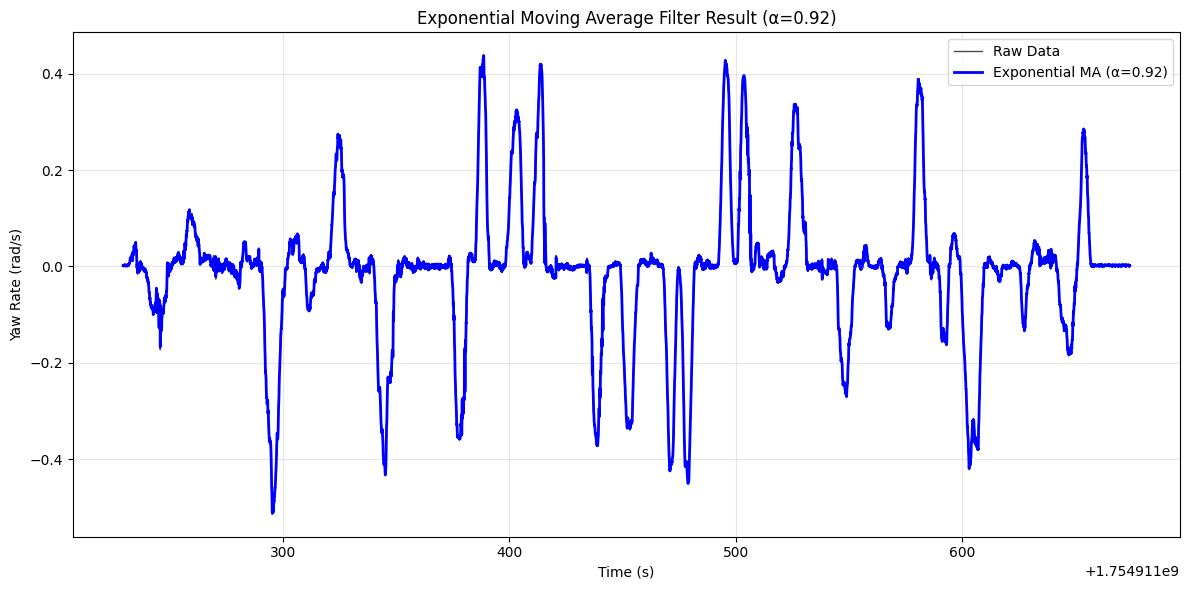

Exponential Moving Average Filter 결과 (α=0.92):
  - 평균: 3.5505 m/s
  - 표준편차: 1.6051 m/s
  - 노이즈 감소율: 0.0%


In [25]:
gnss_data = sensor_data_csv['gnss']
wheel_speed_data = sensor_data_csv['motion_sensor']['average_speed']
yaw_rate_data = sensor_data_csv['motion_sensor']['yaw_rate']

# wheel_speed 데이터 & Yaw rate 데이터 필터링
from tutlibs.motion_sensor.custom_motion_sensor import MotionSensorProcessor

processor = MotionSensorProcessor()

# 이전에 실습했던 Exponential Moving Average Filter 적용
speed_original = wheel_speed_data.copy() / 3.6 # m/s로 변환 (scailing)
yaw_rate_original = yaw_rate_data.copy() * 10.0 # rad/s로 변환 (scailing)

# Exponential Moving Average Filter 적용
alpha = 0.96  # TODO: 평균 속도 필터링 파라미터
speed_original = wheel_speed_data.copy() / 3.6 # m/s로 변환 (scailing)
speed_filtered = processor.exponential_moving_average_filter(speed_original, alpha) # TODO: 이전에 작성했던 Exponential Moving Average Filter 적용
sensor_data_csv['motion_sensor']['average_speed_filtered'] = speed_filtered
alpha = 0.92  # TODO: yaw rate 필터링 파라미터
yaw_rate_filtered = processor.exponential_moving_average_filter(yaw_rate_original, alpha) # TODO: 이전에 작성했던 Exponential Moving Average Filter 적용
sensor_data_csv['motion_sensor']['yaw_rate_filtered'] = yaw_rate_filtered

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(sensor_data_csv['motion_sensor']['timestamp'], speed_original, 'k-', alpha=0.7, linewidth=1, label='Raw Data')
plt.plot(sensor_data_csv['motion_sensor']['timestamp'], speed_filtered, 'b-', linewidth=2, label=f'Exponential MA (α={alpha})')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title(f'Exponential Moving Average Filter Result (α={alpha})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(sensor_data_csv['motion_sensor']['timestamp'], yaw_rate_original, 'k-', alpha=0.7, linewidth=1, label='Raw Data')
plt.plot(sensor_data_csv['motion_sensor']['timestamp'], yaw_rate_filtered, 'b-', linewidth=2, label=f'Exponential MA (α={alpha})')
plt.xlabel('Time (s)')
plt.ylabel('Yaw Rate (rad/s)')
plt.title(f'Exponential Moving Average Filter Result (α={alpha})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Exponential Moving Average Filter 결과 (α={alpha}):")
print(f"  - 평균: {np.mean(speed_filtered):.4f} m/s")
print(f"  - 표준편차: {np.std(speed_filtered):.4f} m/s")
print(f"  - 노이즈 감소율: {(1 - np.std(speed_filtered)/np.std(speed_original))*100:.1f}%")

In [9]:
# 3-2. 데이터 동기화
# GNSS와 IMU, Wheel Speed 데이터의 측정 주기를 확인
print(f"GNSS 데이터 주기: {np.mean(np.diff(sensor_data_csv['gnss']['timestamp'])):.3f}초")
print(f"Wheel Speed & IMU 데이터 주기: {np.mean(np.diff(sensor_data_csv['motion_sensor']['timestamp'])):.3f}초")

# 데이터 동기화
# 0.01초를 기준으로 데이터를 보간
print(f"시간 범위: {start_time:.1f} ~ {end_time:.1f} 초")
print(start_time)
print(end_time)
real_end_time = end_time - start_time
print(f"실제 시간 범위: {real_end_time:.5f} 초")
# 0.01초 간격으로 데이터 생성
time_range = np.arange(0, real_end_time, 0.01)

# time_range에 대해 GNSS 데이터를 보간
print(sensor_data_csv['gnss'].columns)
gnss_data_interpolated_latitude = np.interp(time_range, sensor_data_csv['gnss']['timestamp'] - start_time,sensor_data_csv['gnss']['latitude']) # TODO: GNSS 데이터 보간 - np.interp 활용, 시간 범위: sensor_data_csv['gnss']['timestamp'] - start_time
gnss_data_interpolated_longitude = np.interp(time_range, sensor_data_csv['gnss']['timestamp'] - start_time,sensor_data_csv['gnss']['longitude']) # TODO: GNSS 데이터 보간 - np.interp 활용, 시간 범위: sensor_data_csv['gnss']['timestamp'] - start_time
gnss_data_interpolated_altitude = np.interp(time_range, sensor_data_csv['gnss']['timestamp'] - start_time,sensor_data_csv['gnss']['altitude']) # TODO: GNSS 데이터 보간 - np.interp 활용, 시간 범위: sensor_data_csv['gnss']['timestamp'] - start_time

# Covariance 행렬 보간 (각 요소별로 보간)
interpolated_covariance = data_loader.interpolate_covariance_matrices(
    sensor_data_csv['gnss']['timestamp'] - start_time, sensor_data_csv['gnss']['covariance'], time_range)
# print(interpolated_covariance)

interpolated_gnss_data = {
    'timestamp': time_range,
    'latitude': gnss_data_interpolated_latitude,
    'longitude': gnss_data_interpolated_longitude,
    'altitude': gnss_data_interpolated_altitude,
    'covariance': interpolated_covariance
}

# 보간된 GNSS 데이터 확인
print(f"보간된 GNSS 데이터 포인트 수: {len(interpolated_gnss_data['timestamp'])}")
print(f"원본 GNSS 데이터 포인트 수: {len(sensor_data_csv['gnss']['timestamp'])}")
print(f"보간된 GNSS 데이터 주기: {np.mean(np.diff(interpolated_gnss_data['timestamp'])):.3f}초")
print(f"원본 GNSS 데이터 주기: {np.mean(np.diff(sensor_data_csv['gnss']['timestamp'])):.3f}초")

GNSS 데이터 주기: 0.010초
Wheel Speed & IMU 데이터 주기: 0.002초
시간 범위: 1754911229.5 ~ 1754911673.8 초
1754911229.499661
1754911673.843261
실제 시간 범위: 444.34360 초
Index(['timestamp', 'latitude', 'longitude', 'altitude', 'covariance'], dtype='object')
보간된 GNSS 데이터 포인트 수: 44435
원본 GNSS 데이터 포인트 수: 44878
보간된 GNSS 데이터 주기: 0.010초
원본 GNSS 데이터 주기: 0.010초


In [10]:
# time_range에 대해 motion_sensor 데이터를 보간
print(sensor_data_csv['motion_sensor'].columns)
motion_data_interpolated_fl = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['wheel_speed_fl']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_fr = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['wheel_speed_fr']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_rl = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['wheel_speed_rl']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_rr = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['wheel_speed_rr']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_average_speed = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['average_speed']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_average_speed_filtered = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['average_speed_filtered']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_yaw_rate = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['yaw_rate']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_yaw_rate_filtered = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['yaw_rate_filtered']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_longitudinal_accel = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['longitudinal_accel']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time
motion_data_interpolated_lateral_accel = np.interp(time_range,sensor_data_csv['motion_sensor']['timestamp'] - start_time, sensor_data_csv['motion_sensor']['lateral_accel']) # TODO: 보간 - np.interp 활용, 시간 범위: sensor_data_csv['motion_sensor']['timestamp'] - start_time

interpolated_motion_data = {
    'timestamp': time_range,
    'wheel_speed_fl': motion_data_interpolated_fl,
    'wheel_speed_fr': motion_data_interpolated_fr,
    'wheel_speed_rl': motion_data_interpolated_rl,
    'wheel_speed_rr': motion_data_interpolated_rr,
    'average_speed': motion_data_interpolated_average_speed,
    'average_speed_filtered': motion_data_interpolated_average_speed_filtered,
    'yaw_rate': motion_data_interpolated_yaw_rate,
    'yaw_rate_filtered': motion_data_interpolated_yaw_rate_filtered,
    'longitudinal_accel': motion_data_interpolated_longitudinal_accel,
    'lateral_accel': motion_data_interpolated_lateral_accel,
}

# 보간된 Motion 데이터 확인
print(f"보간된 Motion 데이터 포인트 수: {len(interpolated_motion_data['timestamp'])}")
print(f"원본 Motion 데이터 포인트 수: {len(sensor_data_csv['motion_sensor']['timestamp'])}")
print(f"보간된 Motion 데이터 주기: {np.mean(np.diff(interpolated_motion_data['timestamp'])):.3f}초")
print(f"원본 Motion 데이터 주기: {np.mean(np.diff(sensor_data_csv['motion_sensor']['timestamp'])):.3f}초")

Index(['timestamp', 'wheel_speed_fl', 'wheel_speed_fr', 'wheel_speed_rl',
       'wheel_speed_rr', 'average_speed', 'yaw_rate', 'longitudinal_accel',
       'lateral_accel', 'average_speed_filtered', 'yaw_rate_filtered'],
      dtype='object')
보간된 Motion 데이터 포인트 수: 44435
원본 Motion 데이터 포인트 수: 204405
보간된 Motion 데이터 주기: 0.010초
원본 Motion 데이터 주기: 0.002초


## 3. 좌표계 변환

GNSS에서 제공하는 WGS84 좌표(위도, 경도, 고도)를 지역 좌표계인 ENU(East-North-Up)로 변환합니다.

이전 GNSS 실습 때 사용했던 함수를 가져와 진행합니다.


=== 좌표 변환 ===
rosbags.highlevel.AnyReader를 사용합니다.
📍 기준점: Lat=37.55689064°, Lon=127.04660559°, Height=56.523m
🔄 WGS84 → ENU 변환 중...
✅ ENU 좌표 변환 완료: 44435 포인트

=== ENU 좌표계 분석 ===
East 방향 범위: 468.705 m
North 방향 범위: 292.450 m
Up 방향 범위: 34.605 m
총 수평 이동 거리: 1589.958 m


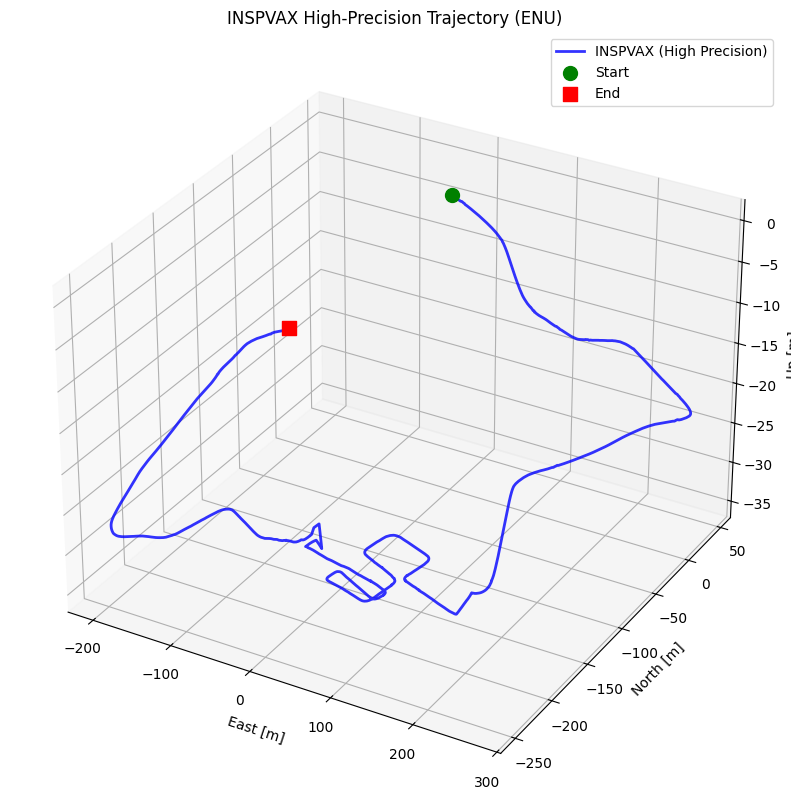

✅ CSV 데이터 좌표 변환 완료!


In [11]:
# 좌표 변환
print("=== 좌표 변환 ===")

# GNSS 데이터
gnss_data_csv = interpolated_gnss_data

# 좌표 변환을 위한 GNSS 처리 객체 생성
from tutlibs.gnss.custom_gnss import GNSSProcessor
gnss_processor = GNSSProcessor()

# 원본 WGS84 좌표 추출
latitudes_csv = gnss_data_csv['latitude']
longitudes_csv = gnss_data_csv['longitude']  
altitudes_csv = gnss_data_csv['altitude']

# LLH 배열 생성
original_llh_csv = np.column_stack([latitudes_csv, longitudes_csv, altitudes_csv]) # TODO: 좌표 변환을 위한 LLH 배열 생성

# 기준점 설정 (첫 번째 점)
reference_point_csv = original_llh_csv[0].copy()

print(f"📍 기준점: Lat={reference_point_csv[0]:.8f}°, Lon={reference_point_csv[1]:.8f}°, Height={reference_point_csv[2]:.3f}m")

# WGS84 → ENU 변환
print("🔄 WGS84 → ENU 변환 중...")
converted_enu_csv = gnss_processor.wgs84_to_enu(original_llh_csv, reference_point_csv) # TODO: 좌표 변환 - 기존에 작성해두었던 gnss_processor.wgs84_to_enu 활용
print(f"✅ ENU 좌표 변환 완료: {len(converted_enu_csv)} 포인트")

# ENU 좌표계 분석
print(f"\n=== ENU 좌표계 분석 ===")
east_range = np.max(converted_enu_csv[:, 0]) - np.min(converted_enu_csv[:, 0])
north_range = np.max(converted_enu_csv[:, 1]) - np.min(converted_enu_csv[:, 1])
up_range = np.max(converted_enu_csv[:, 2]) - np.min(converted_enu_csv[:, 2])

print(f"East 방향 범위: {east_range:.3f} m")
print(f"North 방향 범위: {north_range:.3f} m")
print(f"Up 방향 범위: {up_range:.3f} m")

# 총 이동 거리 계산
total_distance_csv = 0
for i in range(1, len(converted_enu_csv)):
    dx = converted_enu_csv[i, 0] - converted_enu_csv[i-1, 0]
    dy = converted_enu_csv[i, 1] - converted_enu_csv[i-1, 1]
    distance = np.sqrt(dx**2 + dy**2)
    total_distance_csv += distance

print(f"총 수평 이동 거리: {total_distance_csv:.3f} m")

# 3D 궤적 시각화
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# INSPVAX 데이터 (고정밀)
ax.plot3D(converted_enu_csv[:, 0], converted_enu_csv[:, 1], converted_enu_csv[:, 2], 
            c='blue', linewidth=2, label='INSPVAX (High Precision)', alpha=0.8)

# 시작점과 끝점 표시
ax.scatter(converted_enu_csv[0, 0], converted_enu_csv[0, 1], converted_enu_csv[0, 2], 
            c='green', s=100, marker='o', label='Start')
ax.scatter(converted_enu_csv[-1, 0], converted_enu_csv[-1, 1], converted_enu_csv[-1, 2], 
            c='red', s=100, marker='s', label='End')

ax.set_xlabel('East [m]')
ax.set_ylabel('North [m]')
ax.set_zlabel('Up [m]')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('INSPVAX High-Precision Trajectory (ENU)')
plt.show()

print(f"✅ CSV 데이터 좌표 변환 완료!")

## 4. EKF 기반 위치 추정

이제 EKF를 사용하여 GNSS와 IMU 데이터를 융합해 차량의 위치를 추정합니다.

### EKF 설정
- **예측 주기**: 0.01초 (100Hz)
- **GNSS 업데이트**: 0.01초마다 (100Hz)
- **프로세스 노이즈**: 위치, 요(헤딩) 각도 관련 파라미터
- **측정 노이즈**: GNSS 위치 (GNSS에서 실시간으로 제공하는 표준편차)

### 처리 과정
1. **초기화**: 첫 GNSS 위치에서 시작
2. **예측**: IMU, Wheel speed 데이터로 Dead Reckoning
3. **업데이트**: GNSS 데이터로 위치 보정
4. **반복**: 모든 시간에 대해 처리

### 4-1. 시스템 모델 (3-DOF)

**상태 벡터**: $\mathbf{x} = [x, y, \psi]^T$ (3-DOF)
- $x, y$: 차량 위치 (ENU 좌표계)
- $\psi$: 요각 (yaw angle)

**입력 벡터**: $\mathbf{u} = [speed, \dot{\psi}_{IMU}]^T$
- $speed$: 차량의 4개의 wheel로부터 추정된 차량 속도 (직접 사용)
- $\dot{\psi}_{IMU}$: IMU yaw 방향 각속도 (직접 사용)

**측정 벡터**: $\mathbf{z} = [x_{GNSS}, y_{GNSS}]^T$
- GNSS 위치 (WGS84 → ENU 변환 후)

### 4-2. 비선형 상태 전이 함수 (Dead Reckoning 모델)

$$
\mathbf{x}_{k+1} = f(\mathbf{x}_k, \mathbf{u}_k) = \begin{bmatrix}
x_k + v_k \cos(\psi_k) \Delta t \\
y_k + v_k \sin(\psi_k) \Delta t \\
\psi_k + \dot{\psi}_{IMU} \Delta t
\end{bmatrix}
$$

In [12]:
n_step = len(interpolated_motion_data['timestamp'])
dt = np.mean(np.diff(interpolated_motion_data['timestamp']))

num_of_state = 3  # [x, y, yaw]
num_of_measurement = 2  # [x_gnss, y_gnss]
num_of_input = 2  # [speed, yaw_rate]

# Initial conditions (3-DOF)
initial_position_x = converted_enu_csv[0, 0] # TODO: 초기 위치 설정 - converted_enu_csv 활용 (앞:차원/뒤:인덱스)
initial_position_y = converted_enu_csv[1, 0] # TODO: 초기 위치 설정 - converted_enu_csv 활용
initial_speed = interpolated_motion_data['average_speed'][0] # TODO: 초기 속도 설정 - interpolated_motion_data['average_speed'] 활용
initial_yaw = (90.0 - 69.62326370453053) * np.pi / 180.0 # 실제 차량 초기 요각

# Initial state
x_init = np.array([initial_position_x, initial_position_y, initial_yaw])  # TODO: 초기 상태 설정 - [x, y, yaw]

# Initial covariance matrix - P (3x3)
P = np.array(
    [
        [10.0, 0, 0],
        [0, 10.0, 0],
        [0, 0, (np.pi/3)**2],  # 요각 불확실성 (±60도)
    ]
)

# Process noise covariance matrix - Q (3x3)
Q_pose = (0.05*dt)**2 * 10    # 위치 프로세스 노이즈
Q_yaw = (0.1*dt)**2 * 10      # 요각 프로세스 노이즈
Q = np.array(
    [
        [Q_pose, 0, 0],
        [0, Q_pose, 0],
        [0, 0, Q_yaw],
    ]
) # TODO: Q 행렬 작성

# Measurement noise covariance matrix - R (2x2)
R_pose = 2.0**2
R = np.array(
    [
        [R_pose, 0],
        [0, R_pose],
    ]
) # TODO: R 행렬 작성

# Measurement matrix - H (2x3)
H = np.array(
    [
        [1, 0, 0],
        [0, 1, 0]
    ]
) # TODO: H 행렬 작성

print(f"Initial state x_init:\n {x_init}")
print(f"Initial state covariance matrix P:\n {P}")
print(f"Process noise covariance matrix Q:\n {Q}")
print(f"Measurement noise covariance matrix R:\n {R}")
print(f"Measurement matrix H:\n {H}")

Initial state x_init:
 [ 0.00000000e+00 -4.39480395e-08  3.55641139e-01]
Initial state covariance matrix P:
 [[10.          0.          0.        ]
 [ 0.         10.          0.        ]
 [ 0.          0.          1.09662271]]
Process noise covariance matrix Q:
 [[2.5e-06 0.0e+00 0.0e+00]
 [0.0e+00 2.5e-06 0.0e+00]
 [0.0e+00 0.0e+00 1.0e-05]]
Measurement noise covariance matrix R:
 [[4. 0.]
 [0. 4.]]
Measurement matrix H:
 [[1 0 0]
 [0 1 0]]


In [13]:
# 입력 데이터 준비 (새로운 3-DOF 형태)
speed = interpolated_motion_data['average_speed_filtered']
yaw_rate = interpolated_motion_data['yaw_rate_filtered']

u_input = np.array([speed, yaw_rate])  # (2, n_steps) 형태의 입력 데이터
detection_measurement = np.array([converted_enu_csv[:, 0], converted_enu_csv[:, 1]])  # (2, n_steps) 형태의 measurement 데이터

# 결과 저장을 위한 배열 (4-DOF)
n_steps = len(interpolated_motion_data['timestamp'])
x_ekf_prior = np.zeros((3, n_steps))      # 3-DOF state
x_ekf_posterior = np.zeros((3, n_steps))  # 3-DOF state
P_ekf_prior = np.zeros((3, 3, n_steps))   # 3x3 covariance
P_ekf_posterior = np.zeros((3, 3, n_steps))  # 3x3 covariance

# 초기값 설정
x_ekf_prior[:, 0] = x_init
x_ekf_posterior[:, 0] = x_init
P_ekf_prior[:, :, 0] = P
P_ekf_posterior[:, :, 0] = P

### 4-3. 야코비안 행렬 (Jacobian Matrix) - 3-DOF

EKF에서는 비선형 함수를 현재 추정값 주변에서 1차 테일러 전개로 선형화합니다:

$$
\mathbf{F}_k = \frac{\partial f}{\partial \mathbf{x}} \bigg|_{\mathbf{x}_k} = \begin{bmatrix}
1 & 0 & -v_k \sin(\psi_k) \Delta t \\
0 & 1 & v_k \cos(\psi_k) \Delta t \\
0 & 0 & 1
\end{bmatrix}
$$

In [14]:
# 3-DOF EKF 함수들 정의
def f_state_transition_3dof(x_state, u_input, dt):
    """
    3-DOF 상태 전이 함수 (DR model)
    
    Args:
        x_state: [x, y, yaw] - 현재 상태
        u_input: [speed, yaw_rate] - 입력
        dt: 시간 간격
    
    Returns:
        다음 상태 [x_new, y_new, yaw_new]
    """
    x, y, yaw = x_state
    speed, yaw_rate = u_input
    
    # DR 모델 기반 상태 전이
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)
    
    x_new = x + speed * cos_yaw * dt # TODO: x_new 계산
    y_new = y + speed * sin_yaw * dt # TODO: y_new 계산
    yaw_new = yaw + yaw_rate * dt # TODO: yaw_new 계산
    
    # yaw 각도 정규화 (-π ~ π)
    yaw_new = np.arctan2(np.sin(yaw_new), np.cos(yaw_new))
    
    return np.array([x_new, y_new, yaw_new])

def compute_jacobian_F_3dof(x_state, u_input, dt):
    """
    3-DOF 야코비안 행렬 계산
    
    Args:
        x_state: [x, y, yaw] - 현재 상태
        dt: 시간 간격
    
    Returns:
        F: 3x3 야코비안 행렬
    """
    x, y, yaw = x_state
    speed, yaw_rate = u_input
    
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)
    
    F = np.eye(3)
    
    # dx/dyaw
    F[0, 2] = -speed * sin_yaw * dt # TODO: dx/dyaw 계산
    
    # dy/dyaw
    F[1, 2] = speed * cos_yaw * dt # TODO: dy/dyaw 계산
    
    # dyaw/dyaw = 1 (이미 항등행렬에 포함)
    
    return F

print("✅ 3-DOF EKF 함수들 정의 완료")
print("   - f_state_transition_3dof: DR 모델 기반 상태 전이")
print("   - compute_jacobian_F_3dof: 3x3 야코비안 행렬 계산")


✅ 3-DOF EKF 함수들 정의 완료
   - f_state_transition_3dof: DR 모델 기반 상태 전이
   - compute_jacobian_F_3dof: 3x3 야코비안 행렬 계산


### 4-4. EKF 알고리즘

#### 예측 단계 (Prediction)
```
x̂⁻ₖ = f(x̂⁺ₖ₋₁, uₖ₋₁)           (비선형 상태 예측)
P⁻ₖ = FₖP⁺ₖ₋₁Fₖᵀ + Q            (공분산 예측)
```

#### 업데이트 단계 (Update)  
```
Kₖ = P⁻ₖHₖᵀ(HₖP⁻ₖHₖᵀ + R)⁻¹     (칼만 게인)
x̂⁺ₖ = x̂⁻ₖ + Kₖ(zₖ - h(x̂⁻ₖ))      (상태 업데이트)
P⁺ₖ = (I - KₖHₖ)P⁻ₖ              (공분산 업데이트)
```


In [15]:
# EKF 실행 (3-DOF)
print("🚀 3-DOF EKF 위치 추정 시작...")

# GNSS 원본 시간들 (selective update를 위해)
gnss_original_times = sensor_data_csv['gnss']['timestamp'].values - start_time
gnss_tolerance = 0.01  # 100ms tolerance
gnss_update_count = 0

# GNSS 불확실성 threshold
gnss_threshold = 2.5 # TODO: GNSS 데이터 사용 여부에 대한 불확실성 threshold
# TODO: Advanced - 현재 사용 중인 위성 개수에 따라서도 조정 가능

for i in range(1, n_steps):
    current_time = interpolated_gnss_data['timestamp'][i]
    
    # Prediction Step
    x_ekf_prior[:, i] = f_state_transition_3dof(x_ekf_posterior[:, i-1], u_input[:, i-1], dt)  # TODO: 상태 전이 함수 활용
    F_k = compute_jacobian_F_3dof(x_ekf_posterior[:, i-1], u_input[:, i-1], dt) # TODO: 야코비안 행렬 계산
    P_ekf_prior[:, :, i] = F_k @ P_ekf_posterior[:, :, i-1] @ F_k.T + Q  # TODO: 예측 공분산 계산

    # Selective Measurement (원본 GNSS 시간과 가까운 경우만)
    closest_gnss_time_idx = np.argmin(np.abs(gnss_original_times - current_time))
    closest_gnss_time = gnss_original_times[closest_gnss_time_idx]
    
    # 원본 GNSS 시간과 충분히 가까운 경우에만 업데이트
    if abs(current_time - closest_gnss_time) < gnss_tolerance: # TODO: GNSS 데이터 사용 여부에 대한 허용 시간 범위
        # GNSS covariance 신뢰도 체크
        # interpolated_gnss_data['covariance']는 list이므로 직접 인덱싱
        gnss_cov_matrix = interpolated_gnss_data['covariance'][i] # TODO: GNSS 데이터 사용 여부에 대한 불확실성 행렬 활용 - interpolated_gnss_data 데이터 활용
        
        # numpy array 또는 3x3 행렬로 변환
        if isinstance(gnss_cov_matrix, np.ndarray):
            if gnss_cov_matrix.shape == (3, 3):
                cov_3x3 = gnss_cov_matrix
            else:
                cov_3x3 = gnss_cov_matrix.reshape(3, 3)
        else:
            # list나 다른 형태일 경우
            cov_3x3 = np.array(gnss_cov_matrix).reshape(3, 3)
        
        pos_std_x = np.sqrt(cov_3x3[0,0]) # TODO: x 방향 불확실성 (표준편차) 계산
        pos_std_y = np.sqrt(cov_3x3[1,1]) # TODO: y 방향 불확실성 (표준편차) 계산
        
        # 신뢰도 체크: x나 y 중 하나라도 gnss_threshold (m) 를 넘으면 업데이트 하지 않음
        if pos_std_x <= gnss_threshold and pos_std_y <= gnss_threshold: # TODO: 신뢰도 체크 조건 확인
            # 실제 GNSS covariance 사용 (위치 부분만)
            R_dynamic = cov_3x3[:2, :2] # TODO: GNSS 데이터 사용 여부에 대한 불확실성 행렬 활용 - cov_3x3 데이터 활용
            
            # Measurement Update
            K = P_ekf_prior[:, :, i] @ H.T @ np.linalg.inv(H @ P_ekf_prior[:, :, i] @ H.T + R_dynamic) # TODO: 칼만 이득 계산
            x_ekf_posterior[:, i] = x_ekf_prior[:, i] + K @ (detection_measurement[:, i] - H @ x_ekf_prior[:, i]) # TODO: 추정 상태 업데이트
            P_ekf_posterior[:, :, i] = (np.eye(3) - K @ H) @ P_ekf_prior[:, :, i] @ (np.eye(3) - K @ H).T + K @ R_dynamic @ K.T # TODO: 추정 공분산 업데이트
            
            gnss_update_count += 1
        else:
            # 신뢰도가 낮으면 DR만 수행
            x_ekf_posterior[:, i] = x_ekf_prior[:, i]
            P_ekf_posterior[:, :, i] = P_ekf_prior[:, :, i]
    else:
        # GNSS 업데이트 시간이 아니면 DR만 수행
        x_ekf_posterior[:, i] = x_ekf_prior[:, i]
        P_ekf_posterior[:, :, i] = P_ekf_prior[:, :, i]
    
    # 진행률 표시
    if i % 100 == 0:
        progress = i / n_steps * 100
        print(f"진행률: {progress:.1f}%")

print(f"✅ EKF 위치 추정 완료!")
print(f"📊 GNSS 업데이트: {gnss_update_count}/{n_steps} ({gnss_update_count/n_steps*100:.1f}%)")

🚀 3-DOF EKF 위치 추정 시작...
진행률: 0.2%
진행률: 0.5%
진행률: 0.7%
진행률: 0.9%
진행률: 1.1%
진행률: 1.4%
진행률: 1.6%
진행률: 1.8%
진행률: 2.0%
진행률: 2.3%
진행률: 2.5%
진행률: 2.7%
진행률: 2.9%
진행률: 3.2%
진행률: 3.4%
진행률: 3.6%
진행률: 3.8%
진행률: 4.1%
진행률: 4.3%
진행률: 4.5%
진행률: 4.7%
진행률: 5.0%
진행률: 5.2%
진행률: 5.4%
진행률: 5.6%
진행률: 5.9%
진행률: 6.1%
진행률: 6.3%
진행률: 6.5%
진행률: 6.8%
진행률: 7.0%
진행률: 7.2%
진행률: 7.4%
진행률: 7.7%
진행률: 7.9%
진행률: 8.1%
진행률: 8.3%
진행률: 8.6%
진행률: 8.8%
진행률: 9.0%
진행률: 9.2%
진행률: 9.5%
진행률: 9.7%
진행률: 9.9%
진행률: 10.1%
진행률: 10.4%
진행률: 10.6%
진행률: 10.8%
진행률: 11.0%
진행률: 11.3%
진행률: 11.5%
진행률: 11.7%
진행률: 11.9%
진행률: 12.2%
진행률: 12.4%
진행률: 12.6%
진행률: 12.8%
진행률: 13.1%
진행률: 13.3%
진행률: 13.5%
진행률: 13.7%
진행률: 14.0%
진행률: 14.2%
진행률: 14.4%
진행률: 14.6%
진행률: 14.9%
진행률: 15.1%
진행률: 15.3%
진행률: 15.5%
진행률: 15.8%
진행률: 16.0%
진행률: 16.2%
진행률: 16.4%
진행률: 16.7%
진행률: 16.9%
진행률: 17.1%
진행률: 17.3%
진행률: 17.6%
진행률: 17.8%
진행률: 18.0%
진행률: 18.2%
진행률: 18.5%
진행률: 18.7%
진행률: 18.9%
진행률: 19.1%
진행률: 19.4%
진행률: 19.6%
진행률: 19.8%
진행률: 20.0%
진행률: 20.3%
진행률: 20.5%
진행률: 20.7%
진행률: 20.

In [16]:
# 결과 저장 (3-DOF)
std_ekf = np.sqrt(np.diagonal(P_ekf_posterior, axis1=0, axis2=1)).T  # (3, n_steps) 형태
ekf_results = {
    'timestamps': interpolated_gnss_data['timestamp'],  # GNSS 시간 기준 (보간된)
    'states': x_ekf_posterior,        # (3, n_steps): [x, y, yaw]
    'covariances': P_ekf_posterior,   # (3, 3, n_steps)
    'ref_point': reference_point_csv,
    'gnss_data': detection_measurement,  # (2, n_steps): [x_gnss, y_gnss]
    'imu_data': u_input,              # (2, n_steps): [ax, yaw_rate]
    'std_ekf': std_ekf,               # (3, n_steps): 표준편차
    'gnss_update_rate': gnss_update_count / n_steps  # GNSS 업데이트 비율
}

if ekf_results:
    print(f"\n=== 3-DOF EKF 위치 추정 완료 ===")
    print(f"추정 시간 범위: {min(ekf_results['timestamps']):.1f} - {max(ekf_results['timestamps']):.1f} 초")
    print(f"총 추정 샘플: {len(ekf_results['timestamps'])} 개")
    print(f"상태 벡터: [x, y, yaw] (3-DOF)")
    print(f"GNSS 업데이트 비율: {ekf_results['gnss_update_rate']*100:.1f}%")
    print(f"최종 위치: ({x_ekf_posterior[0, -1]:.2f}, {x_ekf_posterior[1, -1]:.2f}) m")
    print(f"최종 요각: {np.degrees(x_ekf_posterior[2, -1]):.1f}°")
    
    # 최종 추정 위치
    final_pos = ekf_results['states'][-1, :2]
    print(f"최종 추정 위치 (ENU): ({final_pos[0]:.2f}, {final_pos[1]:.2f}) m")
    
    # 위치 불확실성
    final_pos_cov = ekf_results['covariances'][-1, :2, :2]
    pos_uncertainty = np.sqrt(np.trace(final_pos_cov))
    print(f"최종 위치 불확실성 (1σ): {pos_uncertainty:.2f} m")
    
    # Ground Truth와 비교 (시뮬레이션인 경우)
    if 'ground_truth' in ekf_results:
        gt_final = ekf_results['ground_truth'][-1, :2]
        final_error = np.linalg.norm(final_pos - gt_final)
        print(f"\n=== Ground Truth 비교 ===")
        print(f"실제 최종 위치: ({gt_final[0]:.2f}, {gt_final[1]:.2f}) m")
        print(f"최종 위치 오차: {final_error:.2f} m")
        
        # 전체 궤적 오차 통계
        all_errors = np.linalg.norm(ekf_results['states'][:, :2] - ekf_results['ground_truth'][:, :2], axis=1)
        print(f"평균 위치 오차: {np.mean(all_errors):.2f} m")
        print(f"최대 위치 오차: {np.max(all_errors):.2f} m")
        print(f"RMS 위치 오차: {np.sqrt(np.mean(all_errors**2)):.2f} m")

else:
    print("❌ EKF 위치 추정에 실패했습니다.")



=== 3-DOF EKF 위치 추정 완료 ===
추정 시간 범위: 0.0 - 444.3 초
총 추정 샘플: 44435 개
상태 벡터: [x, y, yaw] (3-DOF)
GNSS 업데이트 비율: 65.3%
최종 위치: (-123.68, -88.68) m
최종 요각: 64.1°
최종 추정 위치 (ENU): (0.36, 0.36) m
최종 위치 불확실성 (1σ): 0.00 m


In [17]:
# 최종 시점에서의 오차 계산

# 실제 위치
true_x_final = converted_enu_csv[len(converted_enu_csv[:, 0])-1, 0]
true_y_final = converted_enu_csv[len(converted_enu_csv[:, 1])-1, 1]

# 확장 칼만 필터
kf_x_final = ekf_results['states'][0, len(ekf_results['states'][0])-1]
kf_y_final = ekf_results['states'][1, len(ekf_results['states'][1])-1]
kf_error = np.sqrt((kf_x_final - true_x_final)**2 + (kf_y_final - true_y_final)**2)

print(f"실제 최종 위치: ({true_x_final:.2f}, {true_y_final:.2f}) m")
print(f"확장 칼만 필터: ({kf_x_final:.2f}, {kf_y_final:.2f}) m → 오차: {kf_error:.2f} m")

실제 최종 위치: (-123.68, -88.68) m
확장 칼만 필터: (-123.68, -88.68) m → 오차: 0.00 m


## 6. 결과 시각화

이제 7번 칼만 필터에서 사용했던 시각화 함수들을 활용하여 EKF 위치 추정 결과를 자세히 분석해보겠습니다.


=== EKF 추정 결과 상세 분석 ===
(3, 44435)
(44435, 3)
(44435,)
(44435,)
(44435,)


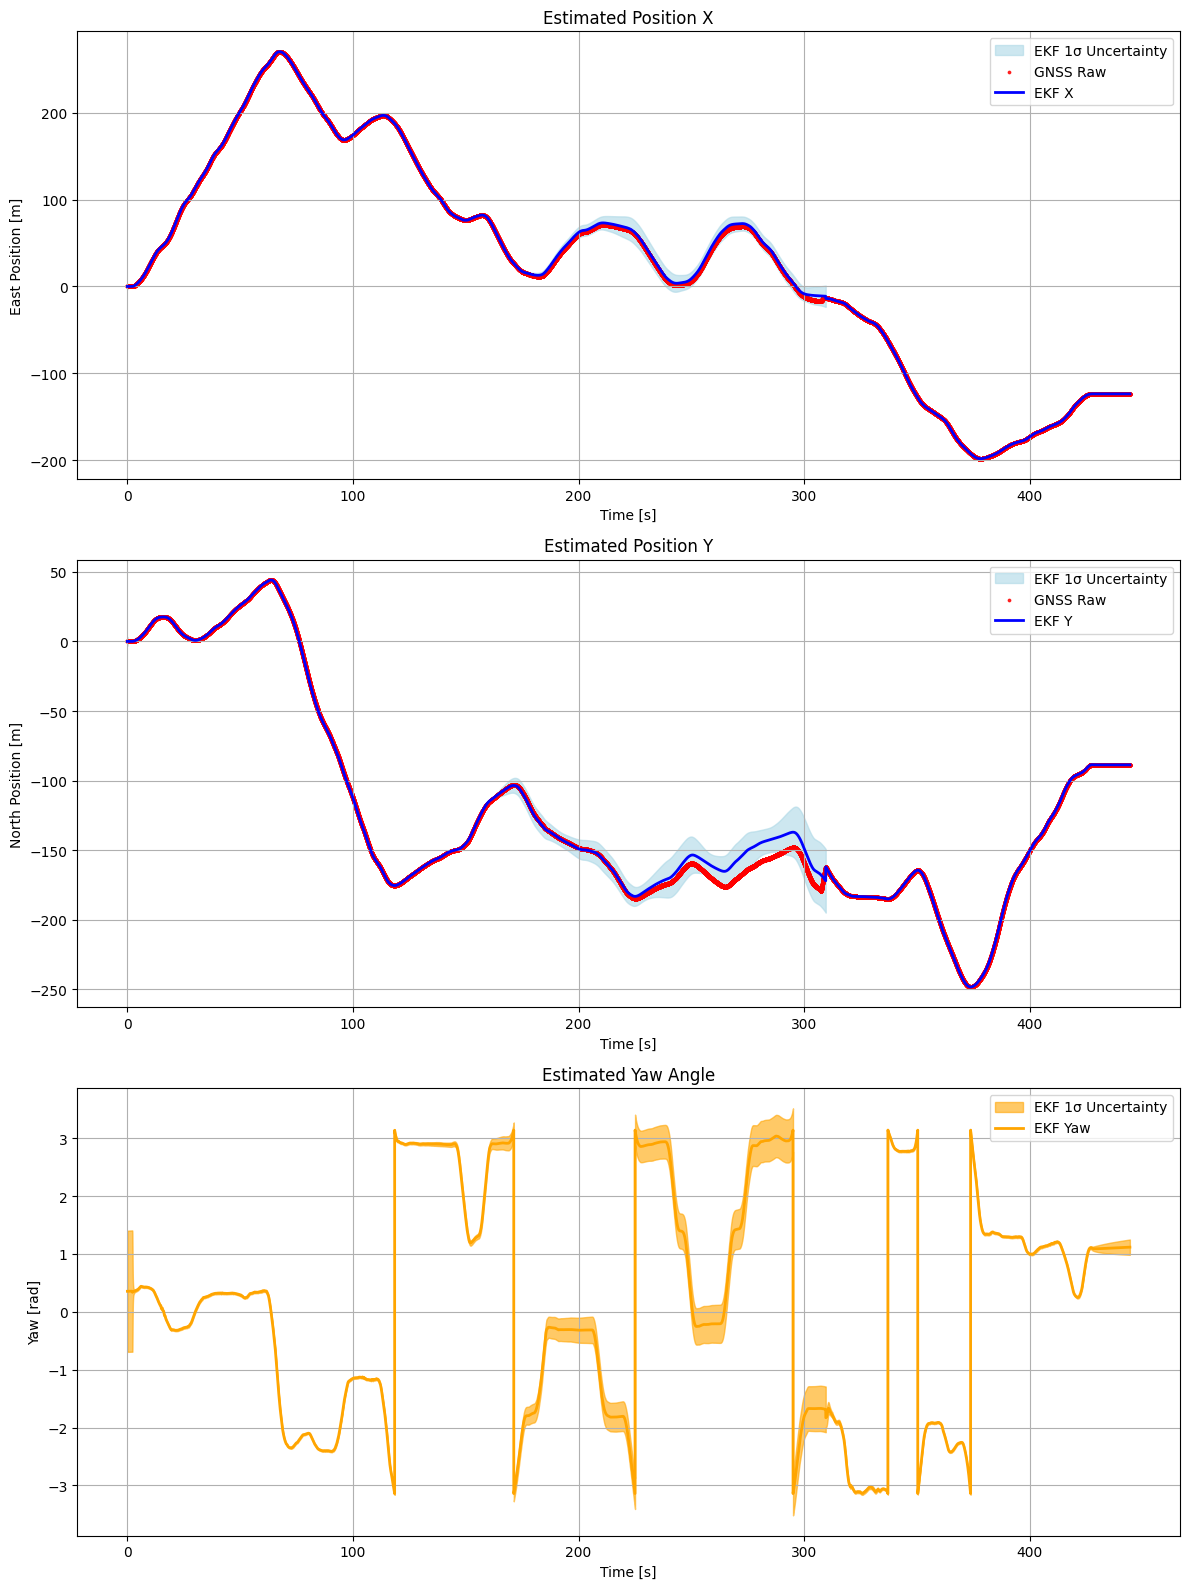

In [18]:
# 6-1. EKF 추정 결과 상세 분석
print("=== EKF 추정 결과 상세 분석 ===")
visualizer = LocalizationVisualizer()
# interpolated_gnss_data를 pd.DataFrame으로 변환
visualizer.plot_estimation_results(interpolated_gnss_data, ekf_results, converted_enu_csv)


In [19]:
# 6-2. 공분산 진화 분석
print("=== 공분산 진화 분석 ===")
visualizer.plot_covariance_evolution(gnss_data, ekf_results)


=== 공분산 진화 분석 ===


In [20]:
# 6-3. 특정 시점에서의 공분산 타원 시각화
sigma = 3.0
print(f"=== 공분산 타원 시각화 - {sigma}σ (여러 시점) ===")

# 시점 선택 (전체 데이터의 균등 분할)
n_total = len(ekf_results['timestamps'])
time_points = [0, n_total//4, n_total//2, 3*n_total//4, n_total-1]

visualizer.plot_covariance_ellipses(gnss_data, ekf_results, time_points=time_points, sigma=sigma)


=== 공분산 타원 시각화 - 3.0σ (여러 시점) ===


🔍 공분산 타원 해석:
- 타원의 크기: 위치 불확실성의 크기
- 타원의 방향: 불확실성의 주축 방향
- GNSS 측정 업데이트 후: 타원이 작아짐 (불확실성 감소)
- 예측 단계: 타원이 커짐 (불확실성 증가)


## 7. 애니메이션 및 위성 지도 시각화


In [21]:
# 7-2. 위성 지도 위에 결과 시각화
print("=== 위성 지도 시각화 ===")

satellite_map = visualizer.create_satellite_map_visualization(
    gnss_data,
    ekf_results,
    ekf_results['ref_point'],
    save_path="ekf_localization_map.html"
)

print("🗺️ 위성 지도 특징:")
print("- 빨간색: GNSS 원시 측정값")
print("- 파란색: EKF 추정 궤적")
print("- 마커: 시작점과 끝점 표시")
print("- 실제 위성 이미지 위에 결과 오버레이")


=== 위성 지도 시각화 ===
위성 지도가 ekf_localization_map.html에 저장되었습니다.
🗺️ 위성 지도 특징:
- 빨간색: GNSS 원시 측정값
- 파란색: EKF 추정 궤적
- 마커: 시작점과 끝점 표시
- 실제 위성 이미지 위에 결과 오버레이


In [22]:
# 위성 지도 시각화
satellite_map

In [23]:
# 7-3. 최적화된 애니메이션 생성 예제
print("=== 최적화된 애니메이션 생성 예제 ===")

# 최적화 옵션 설정
optimization_mode = 4

if optimization_mode == 1:
    print("🐌 전체 데이터 애니메이션 (느림)")
    anim = visualizer.create_localization_animation(
        interpolated_gnss_data,
        converted_enu_csv,
        ekf_results,
        ekf_results['ref_point'],
        save_path='ekf_localization_full.gif',
        fps=10,
        data_fraction=1.0,        # 전체 데이터
        data_region='all',        # 전체 구간
        sampling_step=1           # 모든 프레임
    )
    
elif optimization_mode == 2:
    print("⚡ 빠른 생성 - 시작 부분 10% 구간")
    anim = visualizer.create_localization_animation(
        interpolated_gnss_data,
        converted_enu_csv,
        ekf_results,
        ekf_results['ref_point'],
        save_path='ekf_localization_start_5percent.gif',
        fps=10,
        data_fraction=0.3,        # 10%만 사용
        data_region='start',      # 시작 부분
        sampling_step=6           # 모든 프레임
    )
    
elif optimization_mode == 3:
    print("🚀 매우 빠른 생성 - 전체 구간 1/5 샘플링")
    anim = visualizer.create_localization_animation(
        interpolated_gnss_data,
        converted_enu_csv,
        ekf_results,
        ekf_results['ref_point'],
        save_path='ekf_localization_sampled.gif',
        fps=10,
        data_fraction=0.2,        # 전체 데이터
        data_region='all',        # 전체 구간
        sampling_step=5           # 5프레임마다 1개만
    )

elif optimization_mode == 4:
    print("🚀 매우 빠른 생성 - 전체 구간 1/10 샘플링")
    try:
        anim = visualizer.create_localization_animation(
            interpolated_gnss_data,
            converted_enu_csv,
            ekf_results,
            ekf_results['ref_point'],
            save_path='ekf_localization_fast.gif',
            fps=20,
            data_fraction=0.7,        # 전체 사용
            data_region='start',        # 전체 구간
            sampling_step=10           # 20프레임마다 1개
        )
        print("✅ 애니메이션 생성 완료!")
    except Exception as e:
        print(f"❌ 애니메이션 생성 오류: {e}")


=== 최적화된 애니메이션 생성 예제 ===
🚀 매우 빠른 생성 - 전체 구간 1/10 샘플링
🚀 성능 최적화 적용:
   - 데이터 비율: 70%
   - 구간 선택: start
   - 샘플링 간격: 10
   - 원본 프레임: 44435 → 최적화 프레임: 3111
   - 예상 생성 시간: 51.9분 (원본 대비 7.0%)
애니메이션 생성 중... (총 3111프레임, 20fps)
애니메이션을 ekf_localization_fast.gif에 저장 중...
✅ 애니메이션 저장 완료!%
✅ 애니메이션 생성 완료!


## 8. 성능 분석 및 결론

### 📊 EKF 위치 추정 성능 분석

#### 1. **정확도 분석**
- **위치 추정**: EKF는 GNSS 노이즈를 효과적으로 필터링하여 부드러운 궤적 생성
- **속도 추정**: wheel speed 정보를 활용하여 속도 측정
- **방향 추정**: IMU 요각 속도를 통한 차량 방향 추적

#### 2. **불확실성 관리**
- **공분산 타원**: 시간에 따른 위치 불확실성의 시각적 표현
- **적응적 필터링**: GNSS 신호 품질에 따른 동적 노이즈 모델링
- **센서 융합**: IMU와 GNSS의 최적 결합

#### 3. **시간 동기화**
- **데이터 보간**: 서로 다른 샘플링 레이트의 센서 데이터 동기화
- **실시간 처리**: 0.1초 간격의 연속적인 상태 추정
- **지연 최소화**: 효율적인 예측-업데이트 사이클

### 🚀 실제 자율주행에서의 활용

#### **센서 융합**
- GPS, IMU, 카메라, LiDAR 등 다중 센서 통합
- 각 센서의 장단점을 보완하는 융합 전략

#### **강건성**
- GPS 신호 차단 시 IMU 및 wheel speed sensor 기반 추측 항법
- 환경 변화에 적응하는 동적 모델링

#### **실시간 성능**
- 효율적인 행렬 연산을 통한 실시간 처리
- 메모리 최적화된 데이터 구조